In [47]:
import re
import string
from collections import defaultdict
import pickle
from tqdm import tqdm
from unidecode import unidecode
import matplotlib.pyplot as plt
from collections import Counter
import json
import dill
from utils import beam_search

In [2]:

"""
Splits a paragraph into individual sentences based on punctuation marks.
:param paragraph: str, the input paragraph
:return: list, the sentences
"""
def split_into_sentences(paragraph):
    sentences = re.split(r'(?<!\w\.\w\.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s', paragraph)
    return [sentence.strip() for sentence in sentences if sentence.strip()]


In [7]:
paragraph = "Python is amazing. It is versatile! Do you like Python?"
result = split_into_sentences(paragraph)
print(result)

['Python is amazing.', 'It is versatile!', 'Do you like Python?']


In [8]:
#Loại bỏ các dấu câu
def remove_punctuation(text):
  return "".join([char for char in text if char not in string.punctuation])

In [9]:
sentence = "Kiểm tra thử loại bỏ các dấu câu!!! Ngày mai, trời lại sáng"
remove_punctuation(sentence)

'Kiểm tra thử loại bỏ các dấu câu Ngày mai trời lại sáng'

In [10]:
def remove_punctuation_corpus(corpus):
  corpus_process = []
  for sentence in tqdm(corpus):
    corpus_process.append(remove_punctuation(sentence))
  return corpus_process

In [11]:
def remove_diacritic(text):
    """Hàm loại bỏ dấu tiếng Việt"""
    DIACRITIC_MAP = {
        "áàảãạăắằẳẵặâấầẩẫậ": "a",
        "ÁÀẢÃẠĂẮẰẲẴẶÂẤẦẨẪẬ": "A",
        "éèẻẽẹêếềểễệ": "e",
        "ÉÈẺẼẸÊẾỀỂỄỆ": "E",
        "íìỉĩị": "i",
        "ÍÌỈĨỊ": "I",
        "óòỏõọôốồổỗộơớờởỡợ": "o",
        "ÓÒỎÕỌÔỐỒỔỖỘƠỚỜỞỠỢ": "O",
        "úùủũụưứừửữự": "u",
        "ÚÙỦŨỤƯỨỪỬỮỰ": "U",
        "ýỳỷỹỵ": "y",
        "ÝỲỶỸỴ": "Y",
        "đ": "d",
        "Đ": "D",
    }
    for accents, char in DIACRITIC_MAP.items():
        text = re.sub(f"[{accents}]", char, text)
    return text

In [12]:
file_path = 'train_ipt_500k.pkl'
with open(file_path, 'rb') as f:
    train_ipt_500k = pickle.load(f)

In [16]:
dataset = train_ipt_500k[:5678]
sentences_data = [sent for sentence in dataset for sent in split_into_sentences(sentence)]
#remove_punctuation_corpus(dataset)
print(sentences_data[:10])


['Trang Chính', 'Internet Society', 'Internet Society hay ISOC là một tổ chức quốc tế hoạt động phi lợi nhuận, phi chính phủ và bao gồm các thành viên có trình độ chuyên ngành.', 'Tổ chức này chú trọng đến: tiêu chuẩn, giáo dục và các vấn đề về chính sách.', 'Với trên 145 tổ chức thành viên và 65.000 thành viên cá nhân, ISOC bao gồm những con người cụ thể trong cộng đồng Internet.', 'Mọi chi tiết có thể tìm thấy tại website của ISOC.', 'Internet Society nằm ở gần thủ đô Washington, DC, Hoa Kỳ và Geneva, Thụy Sĩ.', 'Số hội viên của nó bao gồm hơn 145 tổ chức thành viên và hơn 65.000 cá nhân.', 'Thành viên còn có thể tự lập một chi nhánh của tổ chức tùy theo vị trí hoặc sở thích.', 'Hiện nay tổ chức có tới 90 chi nhánh trên toàn thế giới.']


In [18]:
sentences_data_length = [len(sentence) for sentence in sentences_data]
lengths_counts = Counter(sentences_data_length)

In [21]:
print(f"Tổng số lượng câu là: {len(sentences_data)}")
print(f"Độ dài trung bình của các câu: {sum(sentences_data_length) / len(sentences_data)}")
print(f"Độ dài câu dài nhất: {max(sentences_data_length)}")
print(f"Độ dài câu ngắn nhất: {min(sentences_data_length)}")
most_common_length, frequency_max = lengths_counts.most_common(1)[0]
print(f"Độ dài câu xuất hiện nhiều nhất: {frequency_max}")
least_common_length, frequency_min = lengths_counts.most_common()[-1]
print(f"Độ dài câu xuất hiện ít nhất: {frequency_min}")

Tổng số lượng câu là: 17850
Độ dài trung bình của các câu: 138.46935574229693
Độ dài câu dài nhất: 896
Độ dài câu ngắn nhất: 1
Độ dài câu xuất hiện nhiều nhất: 128
Độ dài câu xuất hiện ít nhất: 1


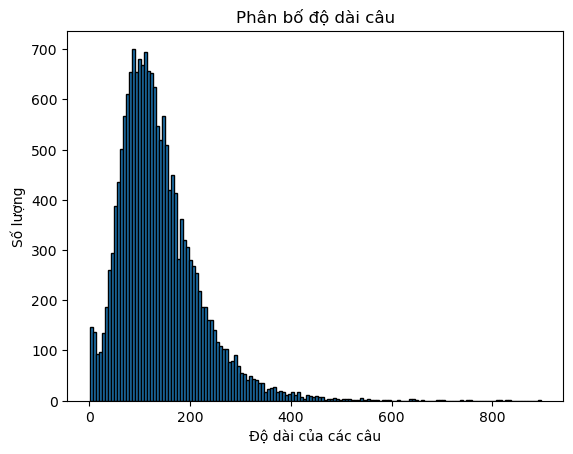

In [20]:
plt.hist(sentences_data_length, bins = 150, edgecolor = "black")
plt.title("Phân bố độ dài câu")
plt.xlabel("Độ dài của các câu")
plt.ylabel("Số lượng")
plt.show()

In [28]:
sentences_data_new = [sentences_data[i] for i in range(len(sentences_data)) if len(sentences_data[i]) < 400]
print(f"Số phần tử của tập dữ liệu: {len(sentences_data_new)}")
sentences_data_length_new = [len(sentence) for sentence in sentences_data_new]

Số phần tử của tập dữ liệu: 17662


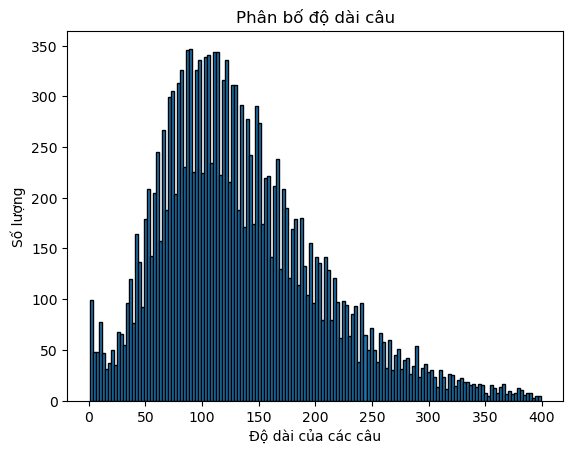

In [29]:
plt.hist(sentences_data_length_new, bins = 150, edgecolor = "black")
plt.title("Phân bố độ dài câu")
plt.xlabel("Độ dài của các câu")
plt.ylabel("Số lượng")
plt.show()

In [48]:
corpus_process = remove_punctuation_corpus(train_dataset_new)
print(corpus_process[:10])

100%|██████████| 5026/5026 [00:00<00:00, 57850.09it/s]

['Trang Chính\n', 'Internet Society\n', 'Internet Society hay ISOC là một tổ chức quốc tế hoạt động phi lợi nhuận phi chính phủ và bao gồm các thành viên có trình độ chuyên ngành Tổ chức này chú trọng đến tiêu chuẩn giáo dục và các vấn đề về chính sách Với trên 145 tổ chức thành viên và 65000 thành viên cá nhân ISOC bao gồm những con người cụ thể trong cộng đồng Internet Mọi chi tiết có thể tìm thấy tại website của ISOC\n', 'Internet Society nằm ở gần thủ đô Washington DC Hoa Kỳ và Geneva Thụy Sĩ Số hội viên của nó bao gồm hơn 145 tổ chức thành viên và hơn 65000 cá nhân Thành viên còn có thể tự lập một chi nhánh của tổ chức tùy theo vị trí hoặc sở thích Hiện nay tổ chức có tới 90 chi nhánh trên toàn thế giới\n', 'Bảo đảm cổ vũ cho sự phát triển mở rộng và sử dụng Internet được thuận lợi nhất cho mọi người trên toàn thế giới\n', 'Tiếng Việt\n', 'Tiếng Việt cũng đã được công nhận là một ngôn ngữ dân tộc thiểu số tại Cộng hòa Séc\n', 'Tổ chức tiêu chuẩn hóa quốc tế đặt mã ngôn ngữ hai chữ

###    **start_prob:** Xác suất để 1 từ là bắt đầu của một câu

    P(s) = (số lần câu bắt đầu bởi từ s) / (tổng số câu)
###   **trans_prob:** Xác suất để một từ xuất hiện sau một từ
    
    P(xt = s' | xt-1 = s) = (Số lần xuất hiện của cặp từ ss') / (Số lần xuất hiện của từ s)

### **emit_prob:** Xác suất phát sinh, xác suất để 1 từ có có dấu tương ứng với từ có dấu

    P(x = o | y = s) = (số lần từ không dấu s tương ứng từ có dấu o) / (Số lượng từ không dấu s)

In [31]:
def compute_probabilities(dataset):
  start_count = defaultdict(int)
  trans_count = defaultdict(lambda: defaultdict(int))
  emit_count = defaultdict(lambda: defaultdict(int))
  for sentence in tqdm(dataset):
    words = sentence.split()
    prev_word = None
    for idx, word in enumerate(words):
      no_diacritic = remove_diacritic(word)
      emit_count[no_diacritic][word] += 1
      if idx == 0:
        start_count[word] += 1
      else:
        trans_count[prev_word][word] += 1
      prev_word = word
    start_prob = {k : v / sum(start_count.values()) for k, v in start_count.items()}
    trans_prob = {k : {k2 : v2 / sum(v.values()) for k2, v2 in v.items()} for k, v in trans_count.items()}
    emit_prob =  {k : {k2 : v2 / sum(v.values()) for k2, v2 in v.items()} for k, v in emit_count.items()}
  return start_count, trans_count , emit_count

In [33]:
start_prob, trans_prob, emit_prob = compute_probabilities(sentences_data)
states = defaultdict(list)
for word in emit_prob:
    states[remove_diacritic(word)].extend(emit_prob[word].keys())

100%|██████████| 17850/17850 [42:34<00:00,  6.99it/s]


In [44]:
obs = "la mot to chuc hoat dong phi loi nhuan,"
result = beam_search(obs.split(" "), states, start_prob, trans_prob, emit_prob)
print("Chuỗi có dấu:", " ".join(result))

Chuỗi có dấu: là một tổ chức hoạt động phi lợi nhuận,


In [42]:
with open('probabilities.dill', 'wb') as f:
    dill.dump((states, start_prob, trans_prob, emit_prob), f)

In [45]:
path = r'D:\Tài liệu học đại học\Project1\Project-1\probabilities.dill' 

with open(path, 'rb') as f:
    states, start_prob, trans_prob, emit_prob = dill.load(f)

In [46]:
obs = "la mot to chuc hoat dong phi loi nhuan,"
result = beam_search(obs.split(" "), states, start_prob, trans_prob, emit_prob)
print("Chuỗi có dấu:", " ".join(result))

Chuỗi có dấu: là một tổ chức hoạt động phi lợi nhuận,
